# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import month_plot,quarter_plot,plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error

# Load the Datasets
We load all the required datasets.
For columns that represent dates (e.g., date), we use parse_dates=["date"] when reading the files to automatically convert them into datetime64 objects. This makes time-based operations much easier more convenient for time series analysis.

## Load and Prepare Data


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/store-sales-time-series-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


## Load and Prepare Data

- **/kaggle/input/store-sales-time-series-forecasting/train.csv** → Load dataset
- **/kaggle/input/store-sales-time-series-forecasting/test.csv** → Load dataset
- **/kaggle/input/store-sales-time-series-forecasting/stores.csv** → Load dataset
- **/kaggle/input/store-sales-time-series-forecasting/transactions.csv** → Load dataset
- **/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv** → Load dataset
- **/kaggle/input/store-sales-time-series-forecasting/oil.csv** → Load dataset
- Convert date fields to datetime


In [3]:
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates=["date"])
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates=["date"])
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates=["date"])
holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=["date"])
holidays=holidays[holidays["transferred"]==False]
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates=["date"])

# Merge Auxiliary Data into df

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

## Merge Auxiliary Data into DataFrame

- Merge datasets (on store_nbr, left join)
- Merge datasets (on [date,store_nbr], left join)
- Merge datasets (on date, left join)
- Merge datasets (on date, left join)
- Handle missing values (e.g., forward-fill)


In [10]:
df = train.merge(stores, on="store_nbr", how="left")
df = df.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
df = df.merge(oil, on="date", how="left")
df = df.merge(holidays[["date","type"]], on="date", how="left")

/tmp/ipykernel_191/3285973314.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")


## Remove Duplicate

In [11]:
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")
df.shape

Removed 30294 duplicate rows.


(3024054, 13)

## Fill Missing values in type_y

## Clean and Preprocess Data

- Impute missing values


In [12]:
df['type_y'] = df['type_y'].fillna('Work Day')

## Average Sales per day_type

In [13]:
df.groupby("type_y", as_index=False)["sales"].mean().sort_values("sales", ascending=False)

,type_y,sales
0,Additional,487.628925
4,Transfer,467.753110
1,Bridge,446.750854
2,Event,425.024432
3,Holiday,359.138598
5,Work Day,351.975641


## Handle Duplicated  in Holidays Events

In [14]:
holiday_priority ={
    'Holiday': 2,
    'Bridge': 4,
    'Transfer': 5,
    'Additional': 6,
    'Work Day': 1,
    'Event': 3
}

In [15]:
holidays["priority"] = holidays["type"].map(holiday_priority)
idx=holidays.groupby("date")["priority"].idxmax()
holidays=holidays.loc[idx].reset_index(drop=True)

# Merge Auxiliary Data into Train

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

## Merge Auxiliary Data into DataFrame

- Merge datasets (on store_nbr, left join)
- Merge datasets (on [date,store_nbr], left join)
- Merge datasets (on date, left join)
- Merge datasets (on date, left join)
- Handle missing values (e.g., forward-fill)


In [16]:
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays[["date","type"]], on="date", how="left")

/tmp/ipykernel_191/1920280977.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")


In [17]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


### Renaming Columns for Clarity

- After merging multiple datasets, some columns inherited generic names like `type_x` and `type_y`.  
- To make the dataset more interpretable, we renamed them:

    - **type_x** (coming from stores.csv) →  **store_type**

        Indicates the type of store (A, B, C, or D).

    - **type_y** (coming from holidays_events.csv) → **day_type**

        Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).

## Clean and Preprocess Data


In [18]:
train = train.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# Merge Auxiliary Data into Test

- **stores.csv** → Adds store-level information (`city`, `state`, `type`, `cluster`).  

- **transactions.csv** → Adds the number of daily transactions for each store (based on `date` + `store_nbr`).  

- **oil.csv** → Adds oil price (`dcoilwtico`) for each date.  

- **holidays_events.csv** → Adds holiday/event type (`type`) for each date.  

**Note**: Unlike the train dataset, the test dataset does not include the `sales` column, because `sales` is the target variable we aim to predict. All other auxiliary data is merged to provide the necessary context for forecasting.  


## Merge Auxiliary Data into DataFrame

- Merge datasets (on store_nbr, left join)
- Merge datasets (on [date,store_nbr], left join)
- Merge datasets (on date, left join)
- Merge datasets (on date, left join)


In [19]:
test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays[["date","type"]], on="date", how="left")
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,NaN


### Renaming Columns for Clarity (Test Set)

- Similar to the train dataset, merging multiple files created generic column names (`type_x`, `type_y`).  
- To make the test dataset more interpretable, we renamed them:

    - **type_x** (from `stores.csv`) → **store_type**  
      Indicates the type of store (A, B, C, or D).  

    - **type_y** (from `holidays_events.csv`) → **day_type**  
      Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).  


## Clean and Preprocess Data


In [20]:
test = test.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# **Dataset Overview**

## Shape of the dataset

In [21]:
train.shape

(3000888, 13)

In [22]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,day_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


## Dataset info (data types + missing values)

In [23]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3000888 non-null  int64         
 1   date          3000888 non-null  datetime64[ns]
 2   store_nbr     3000888 non-null  int64         
 3   family        3000888 non-null  object        
 4   sales         3000888 non-null  float64       
 5   onpromotion   3000888 non-null  int64         
 6   city          3000888 non-null  object        
 7   state         3000888 non-null  object        
 8   store_type    3000888 non-null  object        
 9   cluster       3000888 non-null  int64         
 10  transactions  2755104 non-null  float64       
 11  dcoilwtico    2141964 non-null  float64       
 12  day_type      433026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


## Missing values count

In [24]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions     245784
dcoilwtico       858924
day_type        2567862
dtype: int64

**Columns with Missing Values**  
   - **`transactions` → 249,117 missing (~8.2%)**  
     - Not all stores have transaction logs available.  
     - Missing values can be imputed using median per store or interpolation.  

   - **`dcoilwtico` → 880,308 missing (~28.8%)**  
     - Oil prices are not recorded on weekends and holidays (markets closed).  
     - We can fix it using forward-fill (`ffill`) or interpolation.  

   - **`day_type` → 2,551,824 missing (~83.5%)**  
     - Represents holiday/event types.  
     - Missing values simply mean “regular work day.”  
     - Can safely replace NaN with `"Work Day"`.  

#### Key Takeaways
- Core dataset is very clean (no missing values in essential features like `sales`, `date`, `store_nbr`).  
- Missing values are expected in auxiliary features (transactions, oil prices, holidays).  

In [25]:
test.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dcoilwtico       7128
day_type        26730
dtype: int64

## **Columns with Missing Values — Test Dataset**

- **`transactions` → 28,512 missing (100%)**  
  - All transaction values are missing in the test set.  
  - Since this feature is not available for prediction, we will drop the `transactions` column from both **train** and **test** to keep the datasets aligned.  

- **`dcoilwtico` → 7,128 missing (~2.4%)**  
  - Oil prices are not recorded on weekends and holidays (markets closed).  
  - We can handle missing values using **forward-fill (`ffill`)**.  

- **`day_type` → 26,730 missing (~9.0%)**  
  - Represents holiday/event types.  
  - Missing values simply mean “regular work day.”  
  - We can safely replace NaN with `"Work Day"`.  


## Check duplicates

In [26]:
train.duplicated().sum()

0

In [27]:
test.duplicated().sum()

0

In [28]:
initial_rows = train.shape[0]
train = train.drop_duplicates()
print(f"Removed {initial_rows - train.shape[0]} duplicate rows.")
train.shape

Removed 0 duplicate rows.


(3000888, 13)

**We removed all duplicate rows to ensure data consistency:**  

## Data Validation & Cleaning Checks

## Handle missing values
- Logical imputation strategies:  
  - `transactions`: median per store.  
  - `dcoilwtico`: forward-fill.  
  - `day_type`: fill NaN with `"Work Day"`.  

**Fill missing values of dcoilwtico column with forward-fill then back-fill for any leading NaNs**

## Clean and Preprocess Data

- Impute missing values


In [29]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_191/1575899407.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


**Fill missing values day_type column with "Work Day"**

## Clean and Preprocess Data

- Impute missing values


In [30]:
train['day_type'] = train['day_type'].fillna('Work Day')

In [31]:
train.isnull().sum()


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
transactions    245784
dcoilwtico           0
day_type             0
dtype: int64

**Fill missing values of dcoilwtico column in the test dataset with forward-fill then back-fill for any leading NaNs**

## Clean and Preprocess Data

- Impute missing values


In [32]:
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_191/706933418.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


**Fill missing values day_type column in the test dataset with "Work Day"**

## Clean and Preprocess Data

- Impute missing values


In [33]:
test['day_type'] = test['day_type'].fillna('Work Day')

## **Dropping the `transactions` Column**

To keep the datasets consistent, we drop `transactions` from both **train** and **test**:

In [34]:
train.drop("transactions",axis=1,inplace=True)

In [35]:
test.drop("transactions",axis=1,inplace=True)

In [36]:
train.shape

(3000888, 12)

In [37]:
train['date'] = pd.to_datetime(train['date'])
train.set_index("date",inplace=True)
test.set_index("date",inplace=True)

## Check data types

In [38]:
train.dtypes

id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
city            object
state           object
store_type      object
cluster          int64
dcoilwtico     float64
day_type        object
dtype: object

- **Categorical Columns:** family, city, state, store_type, day_type.  
- **Numeric Columns:** id, store_nbr, sales, onpromotion, cluster, transactions, dcoilwtico.  
- **Datetime Columns:** date.


## List of all columns

In [39]:
train.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'store_type', 'cluster', 'dcoilwtico', 'day_type'],
      dtype='object')

## Unique values exploration

**View all distinct product families available in the dataset.**

In [40]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

**Get unique store types in the dataset**

In [41]:
train.store_type.unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

**Get unique day types in the dataset**

In [42]:
train.day_type.unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

## Count unique values in each column

In [43]:
train.nunique()

id             3000888
store_nbr           54
family              33
sales           379610
onpromotion        362
city                22
state               16
store_type           5
cluster             17
dcoilwtico         994
day_type             6
dtype: int64

## Store Network Structure
- **54 stores** across **22 cities** and **16 states**
- Average of ~2.45 stores per city
- **17 clusters** for geographic or performance grouping
- **5 store types** (A, B, C, D, E) indicating different formats or tiers

## Temporal Coverage
- **1,684 days** of data ≈ **4.6 years** of daily records
- **6 day types** (including Work Day, Holiday, Work Day, Additional, Event, Transfer, Bridge)

## Product & Sales Diversity
- **33 product families** offering diverse category analysis
- **379,610 unique sales values** showing high variability
- **362 promotion levels** indicating varied promotional intensity
- **4,993 transaction count variations** suggesting different store sizes

## Data Quality Indicators
- **3M+ records** with unique IDs - comprehensive dataset
- **994 oil price points** - good external economic indicator coverage

## Descriptive statistics for all columns

In [44]:
train.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_type
count,3.000888e+06,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3000888,3000888,3000888,3.000888e+06,3.000888e+06,3000888
unique,NaN,NaN,33,NaN,NaN,22,16,5,NaN,NaN,6
top,NaN,NaN,AUTOMOTIVE,NaN,NaN,Quito,Pichincha,D,NaN,NaN,Work Day
freq,NaN,NaN,90936,NaN,NaN,1000296,1055868,1000296,NaN,NaN,2574990
mean,1.500444e+06,2.750000e+01,NaN,3.577757e+02,2.602770e+00,NaN,NaN,NaN,8.481481e+00,6.792490e+01,NaN
std,8.662819e+05,1.558579e+01,NaN,1.101998e+03,1.221888e+01,NaN,NaN,NaN,4.649735e+00,2.566913e+01,NaN
min,0.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,1.000000e+00,2.619000e+01,NaN
25%,7.502218e+05,1.400000e+01,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,4.000000e+00,4.637750e+01,NaN
50%,1.500444e+06,2.750000e+01,NaN,1.100000e+01,0.000000e+00,NaN,NaN,NaN,8.500000e+00,5.341000e+01,NaN
75%,2.250665e+06,4.100000e+01,NaN,1.958473e+02,0.000000e+00,NaN,NaN,NaN,1.300000e+01,9.572000e+01,NaN


# Dataset Statistical Summary

### Date
- **Range**: 2013-01-01 → 2017-08-15  
- **Median**: April 26, 2015 → balanced 4.6-year coverage  
- **Temporal spread**: Evenly distributed across the period

### Store Number
- **Range**: Store 1 → Store 54  
- **Mean**: 27.5 → stores evenly distributed numerically  
- **Std**: 15.6 → good spread across store IDs

### Product Family
- **33 unique categories**  
- **Most frequent**: **Automotive** (91,638 entries)  
- Dominant category suggests focus on automotive products

### Sales
- **Range**: $0 → $124,717
  
- **Median**: $11  →  highly right-skewed distribution

  
- **Mean**:  $358.78 (vs Median $11) → extreme outliers present

  
- **Std**: $1,106.76 → very high variability

### On Promotion
- **Range**: 0 → 741 items  
- **Mean**: 2.61 items promoted  
- **75% records**: 0 promotions → sparse promotional activity  
- **Std**: 12.26 → high variation in promotion intensity

### Geography
- **22 cities** → **Top: Quito** (1,008,018 entries)  
- **16 states** → **Top: Pichincha** (1,064,019 entries)  
- Geographic concentration in specific areas

### Store Type
- **5 store types** → **Most frequent: Type D** (1,008,018 entries)  
- Type D dominates the network

### Cluster
- **17 clusters** → Range: 1-17  
- **Mean**: 8.48 → balanced cluster distribution  
- **Std**: 4.65 → moderate variation in cluster sizes

### Transactions
- **Range**: 5 → 8,359 transactions  
- **Median**: 1,395 → right-skewed distribution  
- **Mean**: 1,673 → larger stores pull average up  
- **Std**: 930.65 → significant store size variation

### Oil Price (dcoilwtico)
- **Range**: $26.19 → $110.62  
- **Median**: $53.41 (vs Mean $67.86) → left-skewed distribution  
- **Std**: $25.66 → high volatility in oil prices

### Day Type
- **6 unique day types**  
- **Most frequent**: **Work Day** (2,560,734 entries)  
- Balanced representation of different day types

## Add Feature Engineering

To enhance our dataset with time-related insights, we extract several features from the `date` column.  
This helps capture seasonal patterns, monthly trends, and weekday effects in sales forecasting.

In [45]:
train["Day"]=train.index.day
train["Week_day"]=train.index.strftime("%A")
train['Weekend'] = train["Week_day"].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')

In [46]:
test["Day"]=test.index.day
test["Week_day"]=test.index.strftime("%A")
test['Weekend'] = test["Week_day"].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')

## Decompose Daily Sales Time Series

- **Resample sales** → Aggregate training data to daily frequency using `.resample("D").sum()`.  
- **Apply seasonal decomposition** → Separate trend, seasonality, and residual components with `seasonal_decompose()`.  
- **Visualize decomposition** → Plot additive decomposition with adjusted figure size `(12, 8)`.

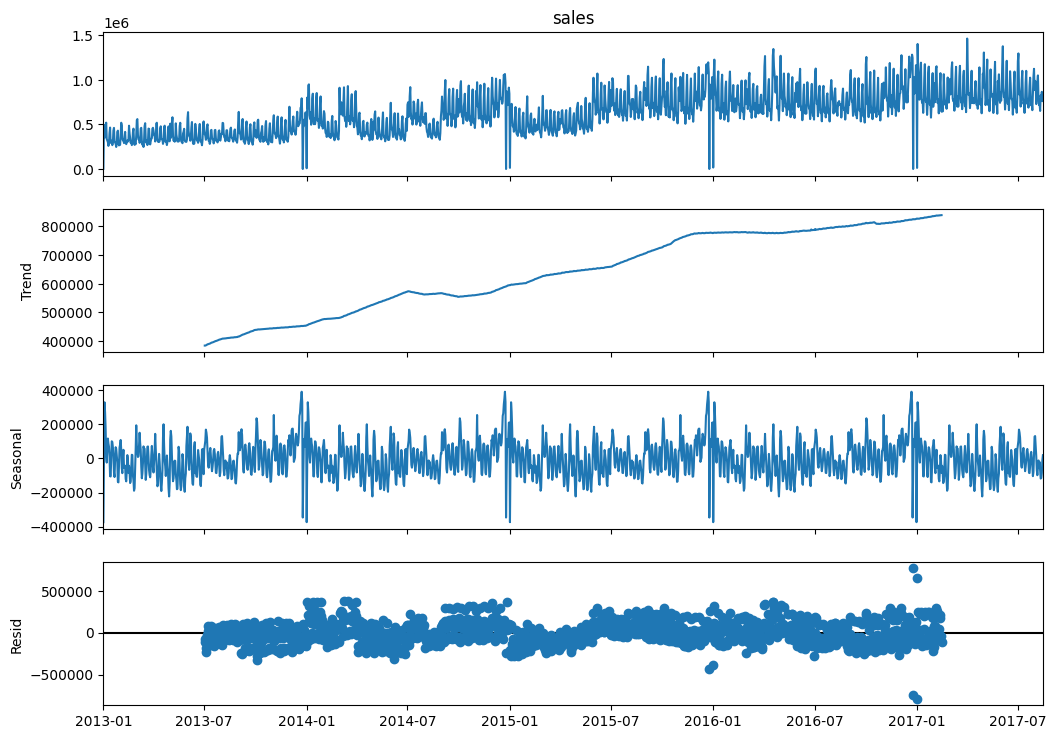

In [47]:
daily_sales = train["sales"].resample("D").sum()

decomposition = seasonal_decompose(daily_sales, model="additive", period=365)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


## Decompose Daily Oil Price Time Series

- **Resample oil price data** → Aggregate `dcoilwtico` to daily frequency using `.resample("D").sum()`.  
- **Apply seasonal decomposition** → Decompose oil price series into trend, seasonal, and residual components with an additive model.  
- **Visualize decomposition** → Display the decomposed components with a 12×8 inch figure.


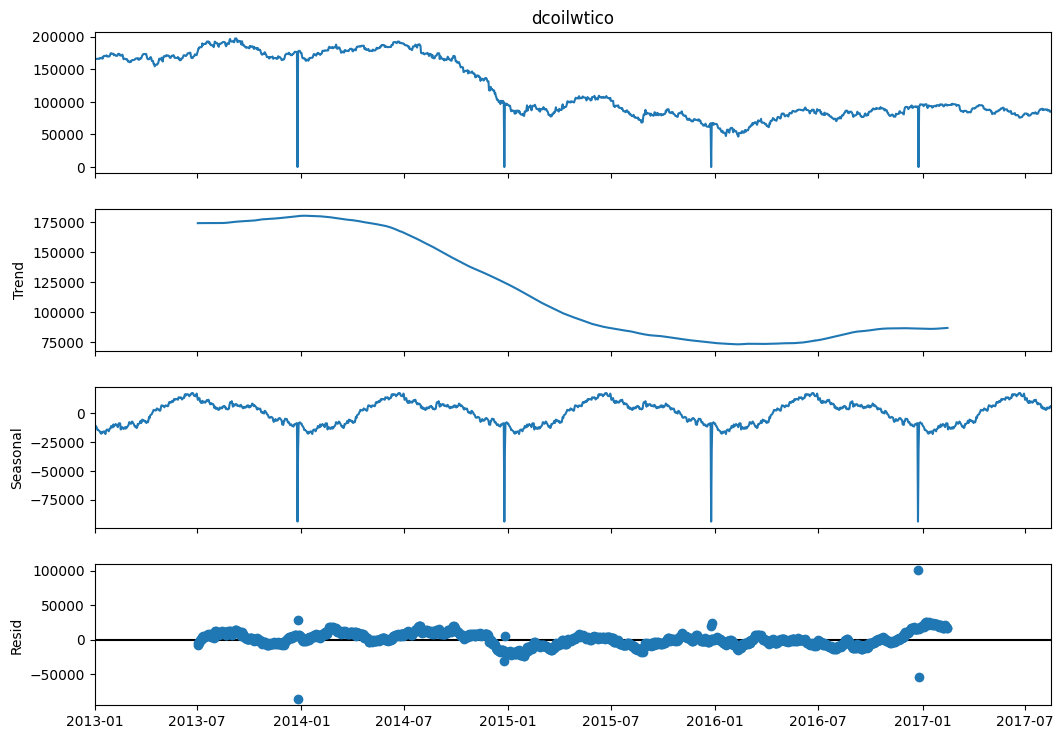

In [48]:
daily_oil = train["dcoilwtico"].resample("D").sum()

decomposition = seasonal_decompose(daily_oil, model="additive", period=365)
fig=decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

## Visualize Monthly Sales Seasonality

- **Aggregate sales monthly** → Resample sales data to monthly totals using `.resample("M").sum()`.  
- **Create month plot** → Use `month_plot()` to visualize recurring monthly patterns in sales.  
- **Customize visualization** → Set labels and title, and display the figure (10×6 inches).


/tmp/ipykernel_191/3092069946.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = train["sales"].resample("M").sum()


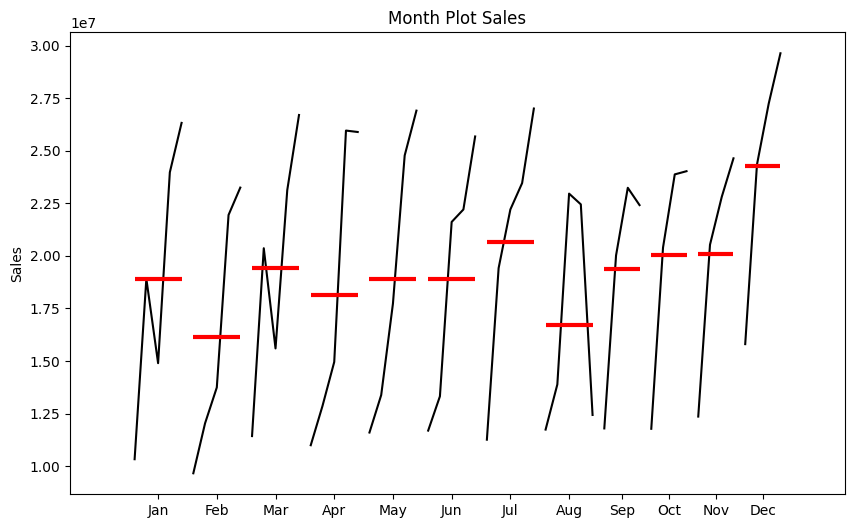

In [49]:
monthly_sales = train["sales"].resample("M").sum()
fig, ax = plt.subplots(figsize=(10,6))
month_plot(monthly_sales, ax=ax)
plt.ylabel("Sales")
plt.title("Month Plot Sales")
plt.show()

## Visualize Quarterly Sales Trends

- **Aggregate sales quarterly** → Resample sales data to quarterly totals using `.resample("Q").sum()`.  
- **Plot quarterly averages** → Use `quarter_plot()` to visualize sales patterns across quarters.  
- **Enhance visualization** → Set figure size (8×5) and add an informative title.



/tmp/ipykernel_191/1760637676.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  series = train["sales"].resample("Q").sum()


<Figure size 800x500 with 0 Axes>

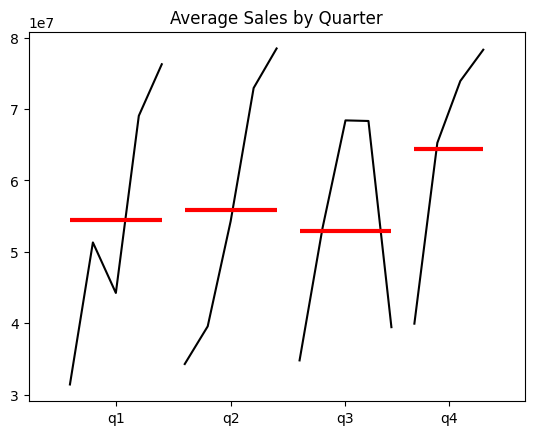

In [50]:
series = train["sales"].resample("Q").sum()  
plt.figure(figsize=(8,5))
quarter_plot(series)
plt.title("Average Sales by Quarter")
plt.show()

## Analyze Sales Distribution by Quarter

- **Extract time features** → Add `year` and `quarter` columns from the datetime index.  
- **Visualize quarterly distribution** → Use `sns.boxplot()` to show sales variation across quarters.  
- **Customize chart** → Label quarters (Q1–Q4), set title, and adjust figure size (8×6).



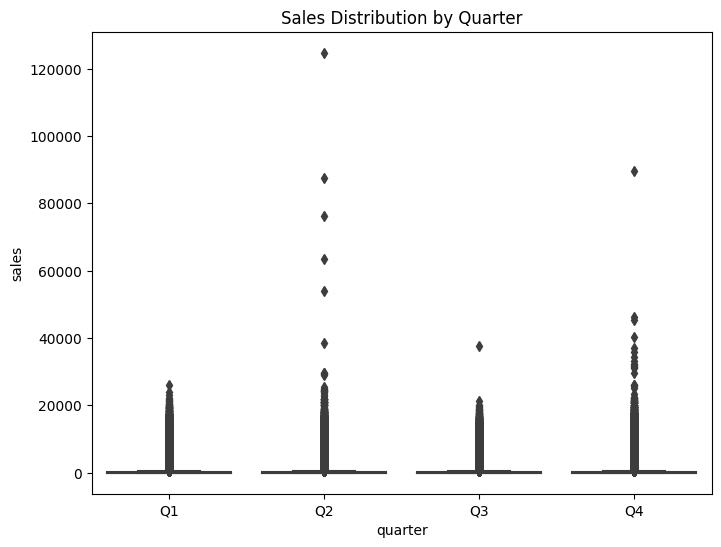

In [51]:
train["year"] = train.index.year
train["quarter"] = train.index.quarter

plt.figure(figsize=(8,6))
sns.boxplot(data=train, x="quarter", y="sales")
plt.title("Sales Distribution by Quarter")
plt.xticks([0,1,2,3], ["Q1","Q2","Q3","Q4"])
plt.show()

# Check Outliers

In [52]:
num_cols=train.select_dtypes(include=["int64","float64"])
for i,col in enumerate(num_cols):
    Q1=train[col].quantile(0.25)
    Q3=train[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outliers=train[col][(train[col]<lower_bound) | (train[col]>upper_bound)]
    print(f"{i+1}: {col} - {len(outliers)}")

1: id - 0
2: store_nbr - 0
3: sales - 447105
4: onpromotion - 611329
5: cluster - 0
6: dcoilwtico - 0


## Handling onpromotion outliers

In [53]:
train["onpromotion"]=np.log1p(train["onpromotion"])

## Test Stationarity of Daily Sales Series

- **Convert index to datetime** → Ensure the DataFrame index is properly formatted as dates.  
- **Resample to daily frequency** → Aggregate sales per day and set a regular daily timescale.  
- **Apply log transformation** → Stabilize variance using `np.log1p()`.  
- **Perform ADF test** → Use `adfuller()` to check for stationarity and print test results.


In [54]:
train.index = pd.to_datetime(train.index, errors='coerce')

ts=train["sales"].resample('D').sum().asfreq('D')
ts_log = np.log1p(ts)
result = adfuller(ts_log.dropna())
print(f'ADF Test')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("Stationary")
else:
    print("Non-Stationary")

ADF Test
ADF Statistic: -4.074579957405862
p-value: 0.0010665908170679162
Stationary


## Examine ACF and PACF of Log-Transformed Sales

- **Define lag window** → Determine maximum lags based on half the series length.  
- **Plot autocorrelation and partial autocorrelation** → Use `plot_acf()` and `plot_pacf()` on log-transformed daily sales.  
- **Visualize temporal dependencies** → Display ACF and PACF plots side-by-side for model order identification.


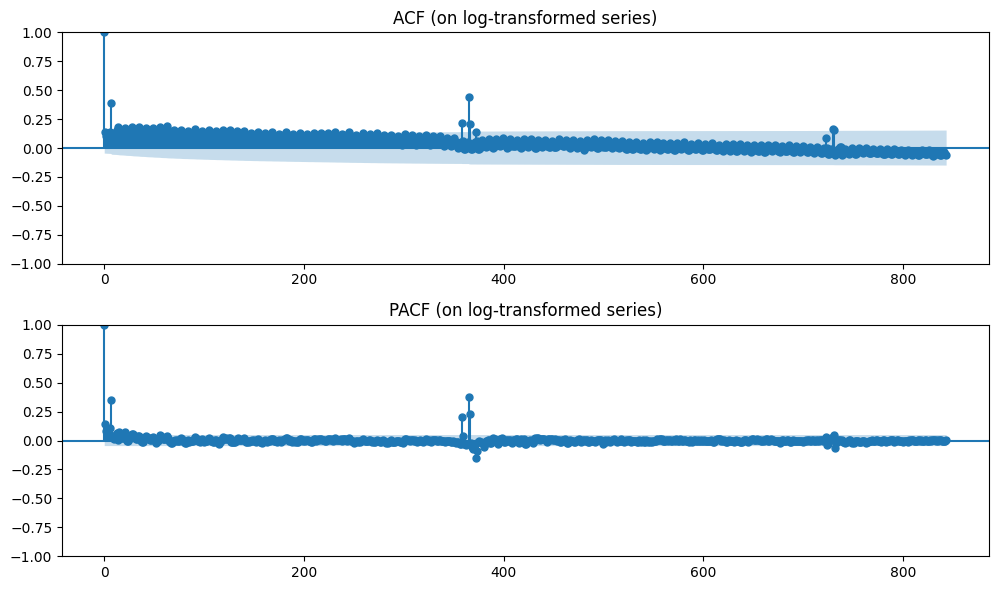

In [56]:
n_obs = len(ts_log.dropna())
max_lags = max(1, n_obs // 2 - 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(ts_log.dropna(), lags=max_lags, ax=ax[0])
plot_pacf(ts_log.dropna(), lags=max_lags, ax=ax[1], method='ywm')

ax[0].set_title("ACF (on log-transformed series)")
ax[1].set_title("PACF (on log-transformed series)")
plt.tight_layout()
plt.show()

## Apply Seasonal Differencing to Log-Transformed Sales

- **Difference the series** → Apply `.diff(182)` to remove yearly seasonality (≈ half-year lag).  
- **Drop missing values** → Use `.dropna()` to clean the differenced series.  
- **Inspect transformed series** → Display the resulting seasonally differenced data.


In [57]:
ts_seasonal_diff = ts_log.diff(182).dropna()
ts_seasonal_diff

date
2013-07-02    5.047278
2013-07-03   -0.281031
2013-07-04   -0.100133
2013-07-05   -0.008665
2013-07-06    0.004524
                ...   
2017-08-11    0.094035
2017-08-12   -0.175748
2017-08-13   -0.216440
2017-08-14   -0.042948
2017-08-15    0.171272
Freq: D, Name: sales, Length: 1506, dtype: float64

## Examine ACF and PACF After Seasonal Differencing

- **Determine lag window** → Compute maximum number of lags from the differenced series length.  
- **Plot ACF and PACF** → Visualize autocorrelation and partial autocorrelation using `plot_acf()` and `plot_pacf()`.  
- **Analyze stationarity** → Inspect patterns after seasonal differencing to guide SARIMA parameter selection.


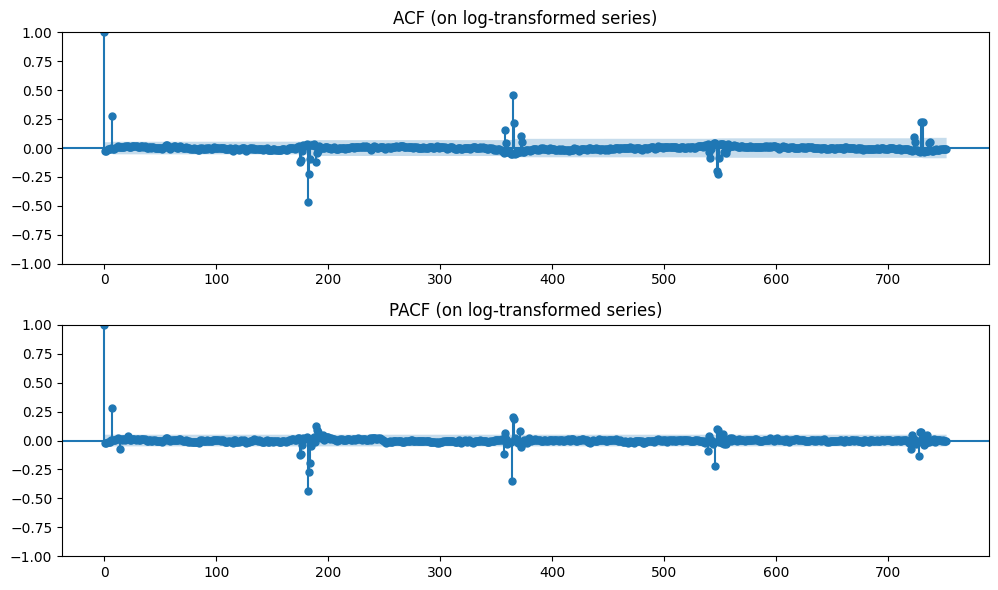

In [58]:
n_obs = len(ts_seasonal_diff)
max_lags = max(1, n_obs // 2 - 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(ts_seasonal_diff, lags=max_lags, ax=ax[0])
plot_pacf(ts_seasonal_diff, lags=max_lags, ax=ax[1], method='ywm')

ax[0].set_title("ACF (on log-transformed series)")
ax[1].set_title("PACF (on log-transformed series)")
plt.tight_layout()
plt.show()

## Split Log-Transformed Series into Train and Test Sets

- **Define split ratio** → Use 80% of the data for training and 20% for testing.  
- **Partition the series** → Slice the log-transformed sales time series into `train` and `test` subsets.  
- **Prepare for modeling** → Ensure temporal order is preserved for time series forecasting.


In [60]:
train_size = int(len(ts_log) * 0.8)
train, test = ts_log.iloc[:train_size], ts_log.iloc[train_size:]

## Fit SARIMAX Model on Training Data
- **SARIMAX parameters** → SARIMA`order=(p,d,q)` and `seasonal_order=(P,D,Q,S)`
- **Configure SARIMAX parameters** → Set `order=(1,1,1)` and `seasonal_order=(1,1,1,182)` to capture trend and yearly seasonality.  
- **Initialize model** → Disable stationarity and invertibility constraints for flexibility.  
- **Train the model** → Fit the SARIMAX model on the training series and display the summary of estimated parameters.


In [61]:
model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,182),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print("\nFinal Model Summary:")
print(results.summary())


Final Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1350
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 182)   Log Likelihood               -1142.432
Date:                             Tue, 14 Oct 2025   AIC                           2294.864
Time:                                     17:04:16   BIC                           2319.317
Sample:                                 01-01-2013   HQIC                          2304.166
                                      - 09-11-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3763      0.006    -60.129      0.000      -0.389      -0.364
ma.L1

## Forecast and Evaluate SARIMAX Model Performance

- **Generate forecasts** → Use `results.get_forecast()` to predict future sales for the test period.  
- **Transform predictions** → Apply `np.expm1()` to revert log-transformed forecasts back to original scale.  
- **Compare predictions vs. actuals** → Clip negative values and align test and forecast series.  
- **Compute evaluation metrics** → Calculate MAE and RMSE as percentages of mean actual sales to assess accuracy.


In [ ]:
n_steps = len(test)
forecast = results.get_forecast(steps=n_steps)


forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


forecast_mean_real = np.expm1(forecast_mean)
forecast_ci_real = np.expm1(forecast_ci)


test_1m = test.iloc[:n_steps]
test_1m_real = np.expm1(test_1m)
y_true = np.maximum(0, test_1m_real)
y_pred = np.maximum(0, forecast_mean_real)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("Mean of Actual Sales:", y_true.mean())
print("\nMAE%:", (mae / y_true.mean()) * 100)
print("\nRMSE%:", (rmse / y_true.mean()) * 100)


Mean of Actual Sales: 845363.9511548316

MAE%: 10.919437857751035

RMSE%: 19.964846495365723


## Invert Log Transformation for Train and Test Data

- **Restore original scale** → Apply `np.expm1()` to reverse the earlier log transformation.  
- **Prepare data for visualization and comparison** → Obtain real (non-log) sales values for both training and testing sets.


In [65]:
train_real = np.expm1(train)
test_real = np.expm1(test)


## Perform Residual Diagnostics for SARIMAX Model

- **Inspect residual behavior** → Use `results.plot_diagnostics()` to assess model adequacy.  
- **Check assumptions** → Evaluate normality, autocorrelation, and standardized residual patterns.  
- **Visualize diagnostics** → Display four key diagnostic plots in a 12×8 inch figure.


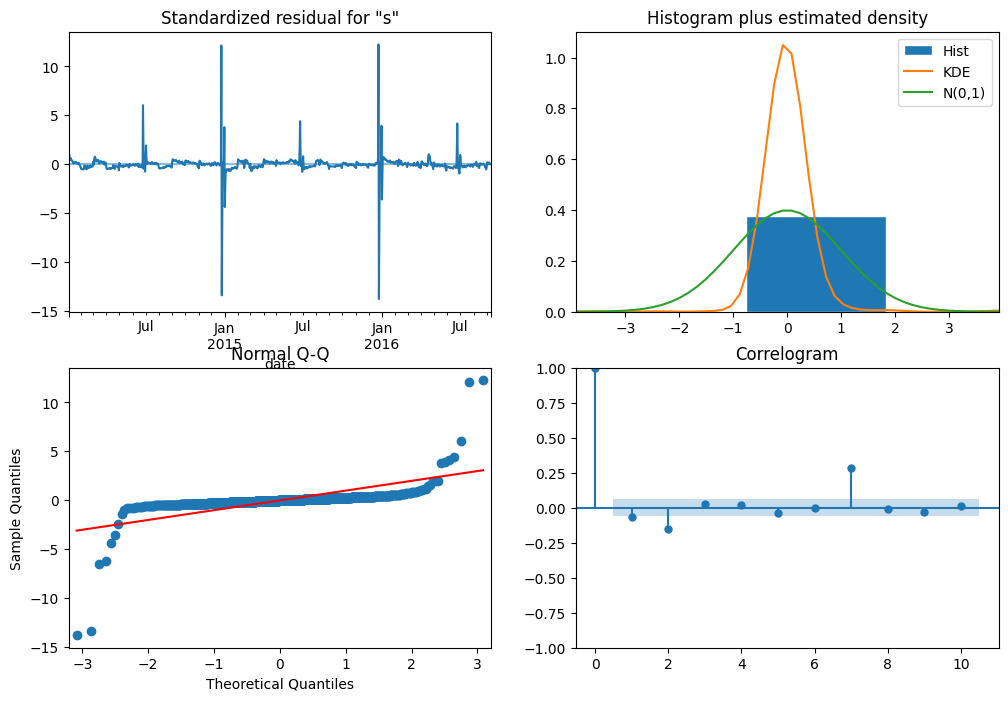

In [ ]:
results.plot_diagnostics(figsize=(12,8))
plt.show()

## Visualize Forecast vs. Actual Sales

- **Plot actual vs. predicted values** → Display training, testing, and forecasted sales series on the same chart.  
- **Add confidence intervals** → Shade forecast uncertainty region using `fill_between()`.  
- **Format and label** → Set title, legend, and format y-axis values in millions for clear interpretation.


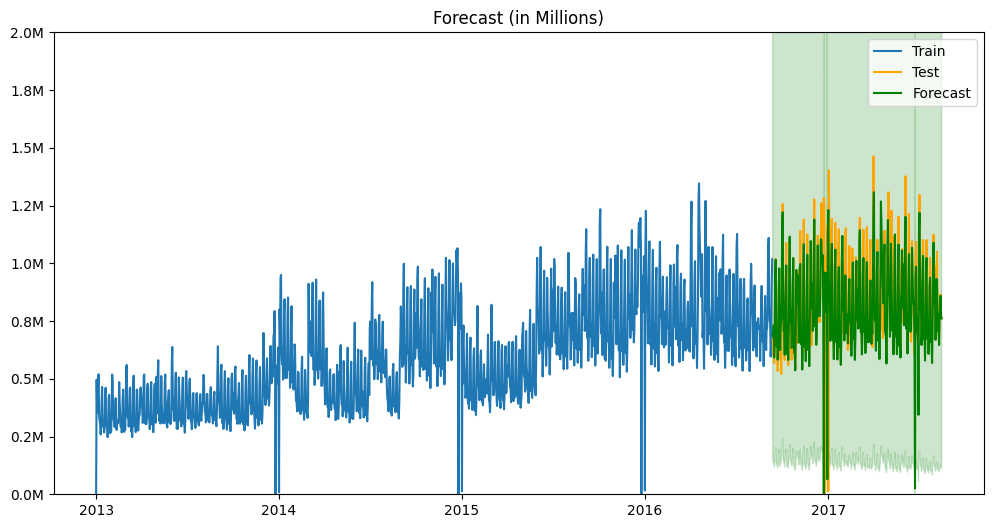

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_real.index, train_real, label='Train')
plt.plot(test_real.index, test_real, label='Test', color='orange')
plt.plot(forecast_mean_real.index, forecast_mean_real, label='Forecast', color='green')

plt.fill_between(forecast_ci_real.index, forecast_ci_real.iloc[:, 0], forecast_ci_real.iloc[:, 1],
                 color='green', alpha=0.2)

plt.legend()
plt.title("Forecast (in Millions)")

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.ylim(0, 2_000_000)
plt.show()


## Analyze Forecast Residuals

- **Compute residuals** → Subtract forecasted sales from actual test values to obtain prediction errors.  
- **Visualize residuals over time** → Plot residuals to identify bias, trends, or heteroscedasticity.  
- **Examine distribution** → Use `sns.histplot()` with KDE to assess normality of residuals.  
- **Check autocorrelation** → Plot ACF of residuals to verify independence of forecast errors.


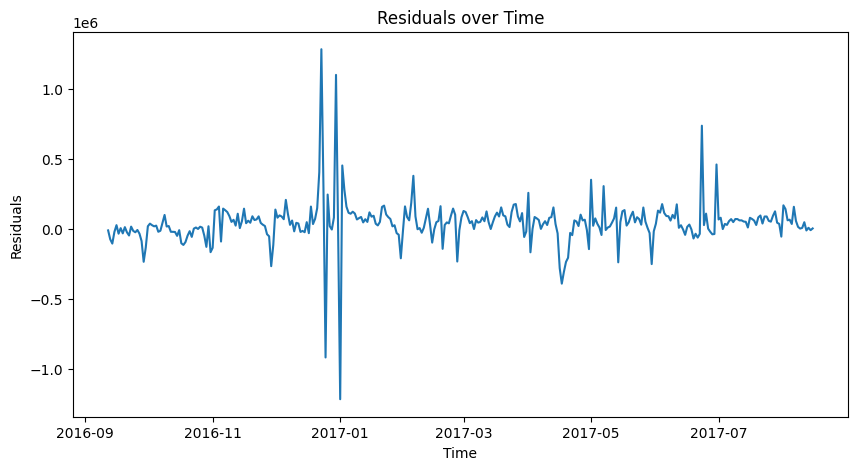

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


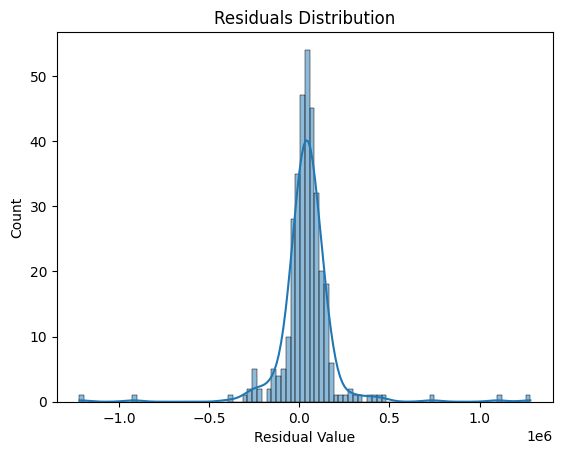

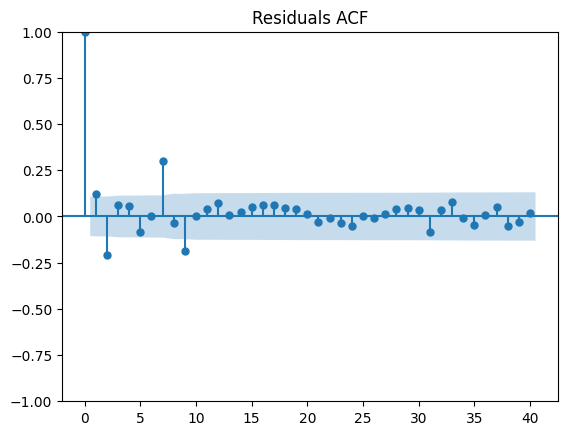

In [76]:
residuals = test_real - forecast_mean_real

plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.show()

plot_acf(residuals, lags=40)
plt.title("Residuals ACF")
plt.show()

## Inspect Residual Behavior and Model Adequacy

- **Time plot of residuals** → Ensure residuals fluctuate randomly around zero with no visible trend.  
- **Residual distribution** → Check if errors follow an approximately normal distribution.  
- **ACF of residuals** → Verify lack of significant autocorrelation, confirming model adequacy.


### 🔍 Key Insights

- **Residual randomness:** Residuals fluctuate around zero without visible trends — indicating the SARIMAX model successfully captured the main time-series structure.  
- **Normality:** The residual distribution is approximately normal, though with slight skewness at the tails, suggesting a few under/over-predicted points.  
- **No autocorrelation:** ACF plot shows most lags within the confidence bounds — confirming that residuals are largely uncorrelated and model assumptions hold.  
- **Model adequacy:** Overall, diagnostics support that the fitted SARIMAX model is statistically sound and suitable for forecasting.
